# So how self-driving cars learn how to see? 

The main technique used by the big companies working on self driving cars is call deep learning. Here we are going to train a relatively simple computer vision model with data taken from Zumi

In [1]:
#from pyimagesearch.trafficsignnet import TrafficSignNet
from zumicloud.zumimlcloudutils import download_dataset_from_cloud, send_model_to_cloud
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pathlib
import os

/opt/tljh/user/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/tljh/user/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/tljh/user/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/tljh/user/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passi

## Get Data from the cloud

In [3]:
dataset_name = 'data.zip'

dataset_directory = 'dataset'

downloaded = download_dataset_from_cloud(dataset_name, dataset_directory)

if downloaded:
    print("Zumi has data for learning")

FileExistsError: [Errno 17] File exists: '/home/jupyter-zumimladmin/dataset'

## Load Data for training

In [2]:
dataset_directory = 'dataset'

### Training data

data_path_train = os.getcwd() +'/'+ dataset_directory + '/' + 'train'

data_dir_train = pathlib.Path(data_path_train)

train_images = list(data_dir_train.glob('*/*'))
train_images = [str(path) for path in train_images]
random.shuffle(train_images)
 
#label_names = np.array([item.name for item in data_dir_train.glob('*')])
label_names = [item.name for item in data_dir_train.glob('*') if item.name != '.ipynb_checkpoints']

label_dict = {name: i for (i,name) in enumerate(label_names)}

train_labels=[label_dict[pathlib.Path(path).parent.name] for path in train_images]
 
data_size=len(train_images)

print(data_size)
print(train_labels)

### Testing data

data_path_test = os.getcwd() +'/'+ dataset_directory + '/' + 'test'

data_dir_test = pathlib.Path(data_path_test)

test_images = list(data_dir_test.glob('*/*'))
test_images = [str(path) for path in test_images]
random.shuffle(test_images)

test_labels=[label_dict[pathlib.Path(path).parent.name] for path in test_images]
 
test_data_size=len(test_images)

print(test_data_size)
print(test_labels)
print(label_names)
print(label_dict)

120
[3, 1, 0, 2, 2, 5, 0, 3, 0, 1, 3, 0, 4, 2, 4, 5, 2, 1, 0, 5, 5, 5, 1, 3, 4, 2, 0, 1, 1, 0, 3, 2, 2, 3, 3, 4, 1, 2, 3, 5, 4, 5, 1, 5, 2, 4, 3, 4, 4, 1, 2, 0, 1, 0, 3, 5, 4, 5, 3, 0, 3, 3, 1, 0, 4, 3, 4, 3, 5, 5, 2, 0, 4, 4, 2, 5, 0, 2, 1, 1, 1, 0, 5, 2, 2, 4, 2, 0, 4, 1, 3, 5, 4, 5, 0, 1, 5, 2, 4, 4, 0, 1, 4, 0, 1, 2, 4, 5, 0, 1, 3, 2, 5, 3, 0, 3, 1, 5, 3, 2]
57
[0, 3, 2, 4, 0, 1, 2, 1, 3, 5, 5, 4, 2, 2, 5, 5, 0, 2, 3, 5, 0, 1, 2, 3, 0, 5, 4, 2, 1, 3, 0, 0, 2, 4, 3, 2, 5, 1, 3, 2, 4, 3, 1, 1, 4, 3, 4, 3, 5, 5, 2, 5, 3, 0, 4, 5, 4]
['Ahead', 'Left', 'Novehicles', 'Right', 'Stop', 'Signals']
{'Ahead': 0, 'Left': 1, 'Novehicles': 2, 'Right': 3, 'Stop': 4, 'Signals': 5}


### Image Preprocessing

In [3]:
IMG_SIZE=32

BATCH_SIZE = 64


def load_split(x, y):
	# initialize the list of data and labels
	data = []
	labels = []

	# loop over the rows of the CSV file
	for (i, imagepath) in enumerate(x):
		# check to see if we should show a status update

		# split the row into components and then grab the class ID
		# and image path
		image = io.imread(imagepath)

		# resize the image to be 32x32 pixels, ignoring aspect ratio,
		# and then perform Contrast Limited Adaptive Histogram
		# Equalization (CLAHE)
		image = transform.resize(image, (IMG_SIZE, IMG_SIZE))
		image = exposure.equalize_adapthist(image, clip_limit=0.1)

		# update the list of data and labels, respectively
		data.append(image)
		labels.append(int(y[i]))

	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)

	# return a tuple of the data and labels
	return (data, labels)

(x_train, y_train) = load_split(train_images, train_labels)
(x_test, y_test) = load_split(test_images, test_labels)

# scale data to the range of [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
 
# one-hot encode the training and testing labels
numLabels  = len(label_names)
y_train = to_categorical(y_train, numLabels)
y_test = to_categorical(y_test, numLabels)
 
# account for skew in the labeled data
classTotals = y_train.sum(axis=0)
classWeight = classTotals.max() / classTotals

## Build deep learning model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


def build(width, height, depth, classes):
	# initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = Sequential()
	inputShape = (height, width, depth)
	chanDim = -1

	# CONV => RELU => BN => POOL
	model.add(Conv2D(8, (5, 5), padding="same",
		input_shape=inputShape))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
	model.add(Conv2D(16, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(16, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
	model.add(Conv2D(32, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(32, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# first set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(128))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))

	# second set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(128))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))

	# softmax classifier
	model.add(Dense(classes))
	model.add(Activation("softmax"))

		# return the constructed network architecture
	return model

In [5]:
model = build(width=32, height=32, depth=3,
	classes=numLabels)

In [6]:
NUM_EPOCHS = 20
INIT_LR = 1e-3
BS = 10

opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))

model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

aug = ImageDataGenerator(
	rotation_range=5,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.25,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

## Train Model

In [7]:
H = model.fit_generator(
	aug.flow(x_train, y_train, batch_size=BS),
	validation_data=(x_test, y_test),
	steps_per_epoch=100,
	epochs=NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)


Epoch 1/20
100/100 [==============================] - 9s 88ms/step - loss: 2.0966 - acc: 0.3280 - val_loss: 2.2281 - val_acc: 0.1930
Epoch 2/20
100/100 [==============================] - 5s 49ms/step - loss: 1.1615 - acc: 0.5810 - val_loss: 3.2102 - val_acc: 0.1930
Epoch 3/20
100/100 [==============================] - 5s 49ms/step - loss: 0.7828 - acc: 0.7120 - val_loss: 4.4334 - val_acc: 0.1930
Epoch 4/20
100/100 [==============================] - 5s 49ms/step - loss: 0.5229 - acc: 0.8280 - val_loss: 4.9114 - val_acc: 0.1930
Epoch 5/20
100/100 [==============================] - 5s 52ms/step - loss: 0.4503 - acc: 0.8380 - val_loss: 4.0454 - val_acc: 0.1930
Epoch 6/20
100/100 [==============================] - 5s 53ms/step - loss: 0.2906 - acc: 0.8990 - val_loss: 3.0811 - val_acc: 0.2456
Epoch 7/20
100/100 [==============================] - 5s 54ms/step - loss: 0.3215 - acc: 0.8940 - val_loss: 0.5468 - val_acc: 0.8421
Epoch 8/20
100/100 [==============================] - 5s 52ms/step - 

### Evaluating Model

[INFO] evaluating network...
              precision    recall  f1-score   support

       Ahead       1.00      0.88      0.93         8
        Left       0.86      0.86      0.86         7
  Novehicles       0.90      0.82      0.86        11
       Right       1.00      1.00      1.00        11
        Stop       1.00      1.00      1.00         9
     Signals       0.85      1.00      0.92        11

    accuracy                           0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57



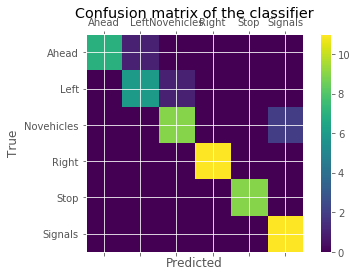

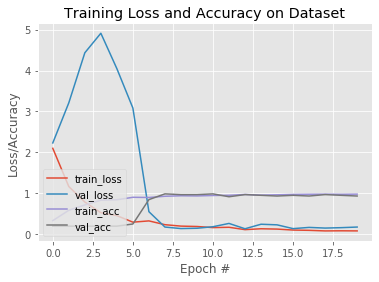

In [21]:
print("[INFO] evaluating network...")
predictions = model.predict(x_test, batch_size=BS)
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_names))

cm = confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + label_names)
ax.set_yticklabels([''] + label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# save the network to disk
#model.save('trafficsignmodel.h5')
#print("[INFO] serializing network to '{}'...".format(args["model"]))
#model.save(args["model"])

# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

## Save model

In [22]:
model_name = 'trafficsigns'

model_path = os.getcwd() + '/' + model_name

os.mkdir(model_path)

model.save_weights(model_path + '/' + model_name + 'weights.h5')
model_json = model.to_json()
with open(model_path + '/' + model_name +'.json',"w") as json_file:
    json_file.write(model_json)
json_file.close()

## Upload Model to the cloud

In [23]:
uploaded = send_model_to_cloud(model_name)

if uploaded:
    print('Your model was uploaded to the cloud')

Your model was uploaded to the cloud
